In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from torchvision import transforms
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.models.instant_ngp import NGPModel

In [43]:
# Clear cache
torch.cuda.empty_cache()

In [44]:
def image_to_tensor(image_path, device) -> torch.Tensor:
    # Open the image using PIL
    image = Image.open(image_path).convert("RGB")
    
    # Define the transform to convert the image to a PyTorch tensor
    transform = transforms.ToTensor()  # This will convert to a tensor with shape (C, H, W)
    
    # Apply the transform
    tensor = transform(image)  # Shape will be (3, 512, 512)
    
    # Permute the tensor to get shape (512, 512, 3)
    tensor = tensor.permute(1, 2, 0).to(device)
    
    return tensor.detach().requires_grad_(False)

def show_image(tensor):
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor.detach().cpu().numpy())
    plt.axis('off')
    plt.show()

In [45]:
class iNeRFOptimizer:
    def __init__(
        self, 
        nerf_model, 
        target_image,
        initial_pose,
        dataparser_matrix,
        dataparser_scale,
        camera_params,
        lr=0.001,
        num_iterations=1000,
        batch_size=4  # Batch size for parallel processing
    ):
        self.nerf_model = nerf_model
        self.device = nerf_model.device
        self.target_image = target_image.to(self.device)
        
        # Set up dataparser transforms
        self.dataparser_matrix = torch.tensor(dataparser_matrix, dtype=torch.float32, device=self.device)
        self.dataparser_scale = dataparser_scale
        
        # Set up camera parameters
        self.camera_params = camera_params
        
        # Create optimizable pose parameter - just the 3x4 part of the transformation matrix
        # Keeping the exact same parameterization as your original
        self.pose_param = nn.Parameter(
            torch.tensor(initial_pose, dtype=torch.float32, device=self.device)[:3, :4].clone(),
            requires_grad=True
        )
        
        # Optimizer
        self.optimizer = optim.AdamW([self.pose_param], lr=lr)
        self.num_iterations = num_iterations
        self.loss_history = []
        
        # Batch size for parallel processing
        self.batch_size = batch_size
        
        # Optional caching
        self.use_cache = True
        self.cache = {}
        self.cache_hits = 0
        self.cache_misses = 0
        
        # Timing statistics
        self.timing_stats = {
            'forward_pass': [],
            'gradient_calculation': [],
            'optimization_step': []
        }
    
    def optimize_step(self, debug=True):
        step_start_time = time.time()
        self.optimizer.zero_grad()
        
        # Finite difference step size - keep exactly the same as your original
        eps = 1e-4
        
        # Get current pose parameters
        pose = self.pose_param.detach().clone()
        
        # Time the forward pass
        forward_start = time.time()
        if self.use_cache:
            original_loss, pred_rgb = self.compute_loss_cached(pose)
        else:
            original_loss, pred_rgb = self.compute_loss_no_grad(pose)
        forward_time = time.time() - forward_start
        self.timing_stats['forward_pass'].append(forward_time)
        
        if debug:
            print(f"Forward pass took {forward_time:.4f} seconds, Loss: {original_loss:.8f}")
            if self.use_cache:
                hit_rate = self.cache_hits / (self.cache_hits + self.cache_misses) * 100 if (self.cache_hits + self.cache_misses) > 0 else 0
                print(f"Cache - Hits: {self.cache_hits}, Misses: {self.cache_misses}, Hit rate: {hit_rate:.1f}%")
        
        # Time the gradient calculation
        grad_start = time.time()
        
        # Get the indices for all parameters
        indices = [(i, j) for i in range(pose.shape[0]) for j in range(pose.shape[1])]
        num_params = len(indices)
        
        # Compute gradients using finite differences - but in batches
        grad = torch.zeros_like(pose)
        
        # Process in batches
        for batch_idx in range(0, num_params, self.batch_size):
            batch_indices = indices[batch_idx:min(batch_idx+self.batch_size, num_params)]
            
            # Create batch of perturbed poses
            batch_poses = []
            for i, j in batch_indices:
                perturbed_pose = pose.clone()
                perturbed_pose[i, j] += eps
                batch_poses.append(perturbed_pose)
            
            # Compute losses for the batch
            batch_losses = []
            for perturbed_pose in batch_poses:
                if self.use_cache:
                    loss_plus, _ = self.compute_loss_cached(perturbed_pose)
                else:
                    loss_plus, _ = self.compute_loss_no_grad(perturbed_pose)
                batch_losses.append(loss_plus)
            
            # Compute gradients using finite difference
            for (i, j), loss_plus in zip(batch_indices, batch_losses):
                grad[i, j] = (loss_plus - original_loss) / eps
            
            if debug and batch_idx + self.batch_size < num_params:
                print(f"  Processed {batch_idx + len(batch_indices)}/{num_params} parameters "
                      f"({(batch_idx + len(batch_indices))/num_params*100:.1f}%)")
        
        grad_time = time.time() - grad_start
        self.timing_stats['gradient_calculation'].append(grad_time)
        
        if debug:
            print(f"Gradient calculation took {grad_time:.4f} seconds")
            print(f"Gradient stats - Min: {grad.min().item():.6f}, Max: {grad.max().item():.6f}, "
                  f"Mean: {grad.mean().item():.6f}, Norm: {grad.norm().item():.6f}")
        
        # Manually set gradients
        self.pose_param.grad = grad
        
        # Time the optimization step
        optim_start = time.time()
        self.optimizer.step()
        optim_time = time.time() - optim_start
        self.timing_stats['optimization_step'].append(optim_time)
        
        total_step_time = time.time() - step_start_time
        if debug:
            print(f"Optimization step took {optim_time:.4f} seconds")
            print(f"Total step took {total_step_time:.4f} seconds")
        
        return original_loss, pred_rgb
    
    def compute_loss_cached(self, pose):
        """Compute loss with caching to avoid redundant computation"""
        # Create a hash for the pose tensor
        pose_key = self._tensor_hash(pose)
        
        if pose_key in self.cache:
            self.cache_hits += 1
            return self.cache[pose_key]
        
        self.cache_misses += 1
        loss, pred_rgb = self.compute_loss_no_grad(pose)
        
        # Store in cache (limiting cache size to prevent memory issues)
        if len(self.cache) < 10000:  # Arbitrary limit
            self.cache[pose_key] = (loss, pred_rgb)
        
        return loss, pred_rgb
    
    def _tensor_hash(self, tensor):
        """Create a hash from tensor values for caching"""
        # Round to reduce floating point precision issues
        rounded = (tensor * 1000).round() / 1000
        return hash(rounded.cpu().numpy().tobytes())
    
    def compute_loss_no_grad(self, pose):
        """Compute loss without requiring gradients - exactly as in your original code"""
        with torch.no_grad():
            # Create camera with the given pose
            camera = Cameras(
                camera_to_worlds=pose.unsqueeze(0),
                fx=self.camera_params["fl_x"],
                fy=self.camera_params["fl_y"],
                cx=self.camera_params["cx"],
                cy=self.camera_params["cy"],
                camera_type=CameraType.PERSPECTIVE,
                height=self.camera_params["h"],
                width=self.camera_params["w"],
            )
            
            # Get outputs using the model's built-in method for rendering
            outputs = self.nerf_model.get_outputs_for_camera(camera)
            
            # Compute loss
            pred_rgb, image = self.nerf_model.renderer_rgb.blend_background_for_loss_computation(
                pred_image=outputs["rgb"],
                pred_accumulation=outputs["accumulation"],
                gt_image=self.target_image,
            )
            
            loss = self.nerf_model.rgb_loss(image, pred_rgb)
            
        return loss.item(), pred_rgb

    def run_optimization(self, visualize_every=50, debug_frequency=10):
        best_loss = float('inf')
        best_pose = None
        best_image = None
        
        print("Starting optimization...")
        overall_start_time = time.time()
        
        for i in range(self.num_iterations):
            iter_start_time = time.time()
            
            # Only output debug info periodically
            debug_this_iter = (i % debug_frequency == 0) or (i < 3)
            
            loss, pred_rgb = self.optimize_step(debug=debug_this_iter)
            self.loss_history.append(loss)
            
            iter_time = time.time() - iter_start_time
            
            if loss < best_loss:
                best_loss = loss
                best_pose = self.pose_param.detach().clone()
                best_image = pred_rgb.detach().clone()
            
            if i % visualize_every == 0 or i == self.num_iterations - 1:
                elapsed_time = time.time() - overall_start_time
                remaining_iters = self.num_iterations - i - 1
                est_time_left = (iter_time * remaining_iters) if i > 0 else 0
                
                print(f"\nIteration {i+1}/{self.num_iterations}, Loss: {loss:.8f}")
                print(f"Current pose:\n{self.pose_param.detach().cpu().numpy()}")
                print(f"Time for this iteration: {iter_time:.2f}s, Total elapsed: {elapsed_time:.2f}s")
                print(f"Estimated time remaining: {est_time_left:.2f}s ({est_time_left/60:.2f}m)")
                
                if visualize_every > 0:
                    self.visualize_progress(i, loss, pred_rgb)
        
        total_time = time.time() - overall_start_time
        print(f"Optimization completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        print(f"Best loss: {best_loss:.8f}")
        
        return best_pose, best_image, best_loss, self.loss_history
    
    def visualize_progress(self, iteration, loss, pred_rgb):
        """Visualize the current progress"""
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(self.target_image.detach().cpu().numpy())
        plt.title("Target Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred_rgb.detach().cpu().numpy())
        plt.title(f"Current Render (Loss: {loss:.8f})")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.plot(self.loss_history)
        plt.title("Loss History")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        plt.tight_layout()
        plt.show()

In [46]:
config_path = Path("/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml")
_, pipeline, _, _ = eval_setup(config_path=config_path, test_mode="inference")
nerf_model = pipeline.model
nerf_device = nerf_model.device

# Load dataparser transforms
dataparser_transforms_path = Path("/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/dataparser_transforms.json")
with open(dataparser_transforms_path, "r") as f:
    dataparser_transform = json.load(f)

dataparser_matrix = torch.tensor(dataparser_transform["transform"], dtype=torch.float32)
dataparser_matrix = np.vstack((dataparser_matrix, np.array([[0, 0, 0, 1]])))
dataparser_scale = dataparser_transform["scale"]

# Initial camera pose
initial_pose = np.array([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0, 0, 0, 1],
])

# Apply dataparser transform
final_initial_pose = np.dot(dataparser_matrix, initial_pose)
final_initial_pose[:3, 3] = final_initial_pose[:3, 3] * dataparser_scale

# Camera parameters
camera_params = {
    "camera_angle_x": 0.5235987755982988,
    "camera_angle_y": 0.5235987755982988,
    "fl_x": 955.4050067376327,
    "fl_y": 955.4050067376327,
    "k1": 0, "k2": 0, "k3": 0, "k4": 0, "p1": 0, "p2": 0,
    "is_fisheye": False,
    "cx": 256.0, "cy": 256.0,
    "w": 512, "h": 512,
    "aabb_scale": 32,
}

# Load target image
target_image_path = "/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png"
target_image = image_to_tensor(target_image_path, nerf_device)




Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

Starting optimization...
Forward pass took 0.9525 seconds, Loss: 0.04274300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gradient calculation took 11.0676 seconds
Gradient stats - Min: -0.162162, Max: 0.190064, Mean: 0.012902, Norm: 0.306887
Optimization step took 0.0004 seconds
Total step took 12.0211 seconds

Iteration 1/1000, Loss: 0.04274300
Current pose:
[[-0.21048152 -0.20813316 -0.96058184 -0.10758684]
 [-0.95663786  0.16839163  0.19326948  0.22200076]
 [ 0.11961164  0.9493719  -0.24021281 -0.27912349]]
Time for this iteration: 12.02s, Total elapsed: 12.02s
Estimated time remaining: 0.00s (0.00m)


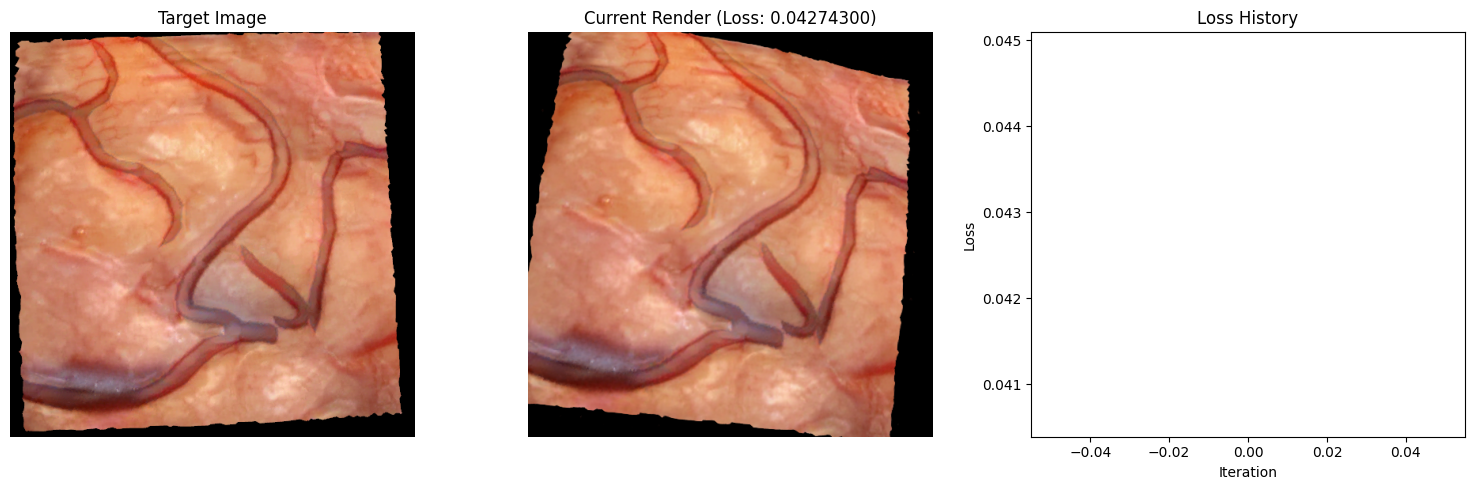

Forward pass took 0.9193 seconds, Loss: 0.04046661
Gradient calculation took 11.0217 seconds
Gradient stats - Min: -0.250489, Max: 0.241734, Mean: -0.006839, Norm: 0.542357
Optimization step took 0.0003 seconds
Total step took 11.9422 seconds
Forward pass took 0.9234 seconds, Loss: 0.04030366
Gradient calculation took 11.0843 seconds
Gradient stats - Min: -0.425614, Max: 0.442192, Mean: 0.024249, Norm: 0.711093
Optimization step took 0.0004 seconds
Total step took 12.0234 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Iteration 6/1000, Loss: 0.03651380
Current pose:
[[-0.20045017 -0.19411643 -0.9751393  -0.09259447]
 [-0.95347613  0.12197029  0.19868104  0.21703035]
 [ 0.07813139  0.90952295 -0.25359356 -0.26170307]]
Time for this iteration: 12.06s, Total elapsed: 72.62s
Estimated time remaining: 11982.77s (199.71m)


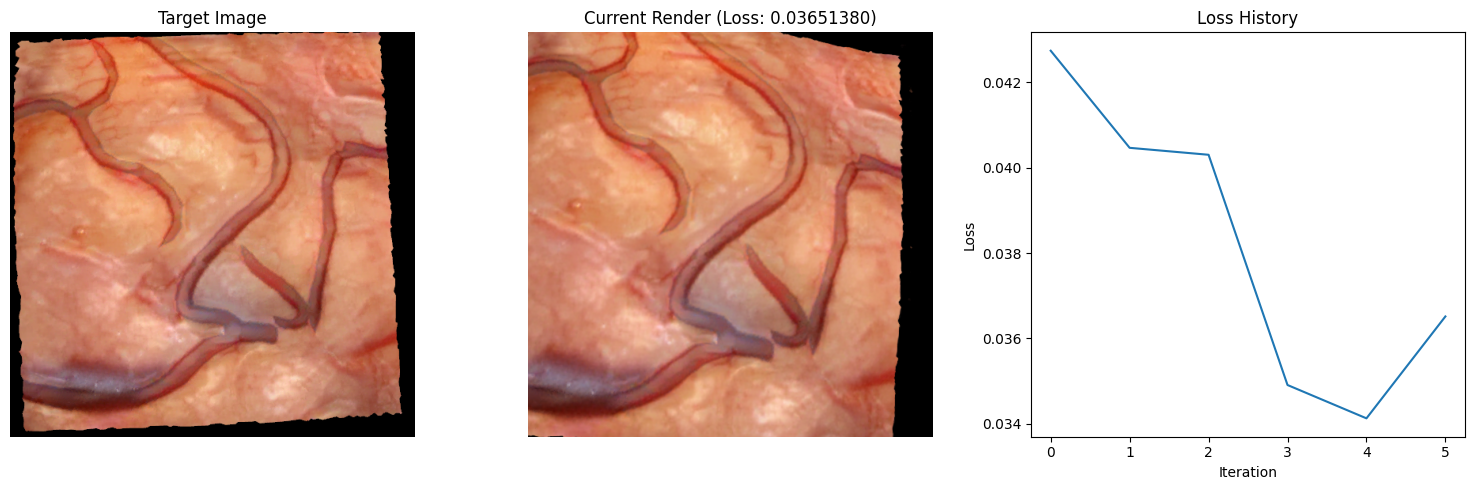

Forward pass took 0.9238 seconds, Loss: 0.02820265


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gradient calculation took 11.0955 seconds
Gradient stats - Min: -0.276379, Max: 0.255369, Mean: 0.010765, Norm: 0.425320
Optimization step took 0.0004 seconds
Total step took 12.0205 seconds

Iteration 11/1000, Loss: 0.02820265
Current pose:
[[-0.19854026 -0.2099853  -0.9795308  -0.09070407]
 [-0.9619033   0.07766886  0.19920649  0.2168238 ]
 [ 0.04334622  0.8990947  -0.24370737 -0.2701234 ]]
Time for this iteration: 12.02s, Total elapsed: 133.29s
Estimated time remaining: 11888.34s (198.14m)


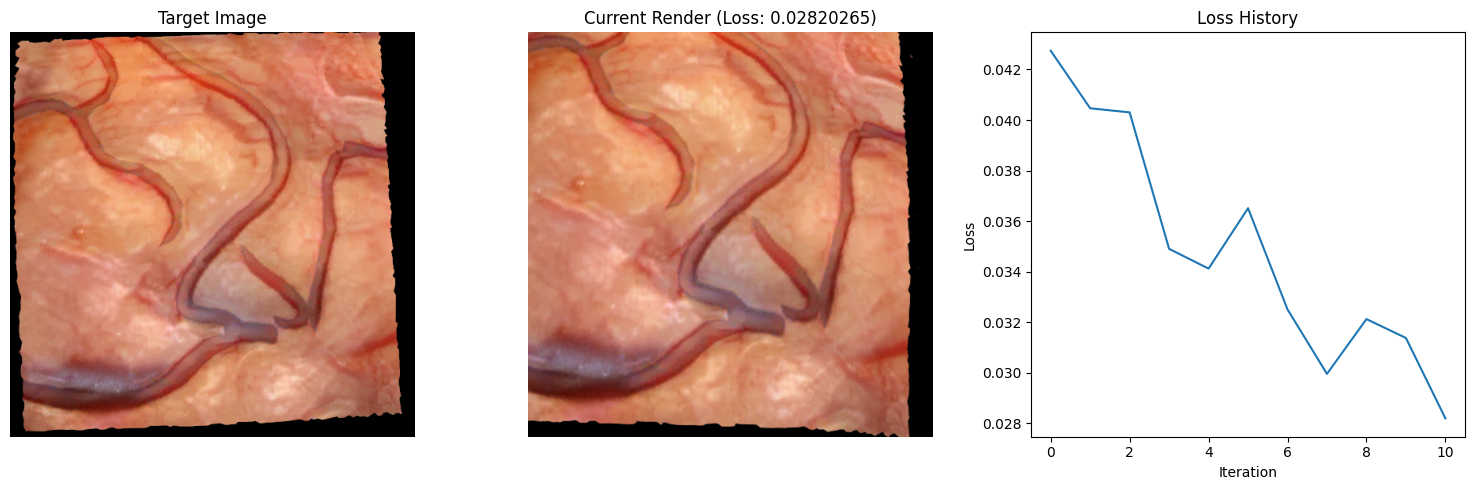

KeyboardInterrupt: 

In [47]:
inerf_optimizer = iNeRFOptimizer(
    nerf_model=nerf_model,
    target_image=target_image,
    initial_pose=final_initial_pose,
    dataparser_matrix=dataparser_matrix,
    dataparser_scale=dataparser_scale,
    camera_params=camera_params,
    lr=0.01,
    num_iterations=1000,
    batch_size=12
)

inerf_optimizer.use_cache = False  # Set to False if you're concerned about memory

best_pose, best_image, best_loss, loss_history = inerf_optimizer.run_optimization(visualize_every=5)